## Topic modelling: tests with the  Latent Dirichlet Allocation (LDA) algorithm.
***

### 1. Initialization of the R environment.
***
The first step is to load the required libraries. 

In [1]:
rm(list=ls()) ## clear objects from memory

options(warn = -1)

## install.packages('repr')

library(tm)
library(ggplot2)
library(textmineR)
library(tidytext)
library(dplyr)
library(tidyr)
library(repr)



Loading required package: NLP


Attaching package: 'ggplot2'


The following object is masked from 'package:NLP':

    annotate


Loading required package: Matrix


Attaching package: 'textmineR'


The following object is masked from 'package:Matrix':

    update


The following object is masked from 'package:stats':

    update



Attaching package: 'dplyr'


The following objects are masked from 'package:stats':

    filter, lag


The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union



Attaching package: 'tidyr'


The following objects are masked from 'package:Matrix':

    expand, pack, unpack




### 2. Data input.
***

We read two of the files extracted from the database, with the glossary articles definitions in _ESTAT_dat_concepts_2021_04_08.csv_ and their titles in _ESTAT_dat_link_info_2021_04_08.csv_. The common key is _id_. **At a later stage, the reading of the files will be directly from the KD**. 

We then drop articles with missing titles and/or definitions and also de-duplicate the records of the resulting file based on these two fields.



In [2]:
dat1 <- read.csv2('.//Data//ESTAT_dat_concepts_2021_04_08.csv')
dat2 <- read.csv2('.//Data//ESTAT_dat_link_info_2021_04_08.csv')
dat <- merge(dat1,dat2,by=c('id'),all=FALSE)
dat <- dat[,c('title','definition')]

dels <- which(is.na(dat$title))
if(length(dels)>0) dat <- dat[-dels,]

dels <- which(is.na(dat$definition))
if(length(dels)>0) dat <- dat[-dels,]

dels <-which(duplicated(dat$title))
if(length(dels)>0) dat <- dat[-dels,]

dels <- which(duplicated(dat$definition))
if(length(dels)>0) dat <- dat[-dels,]

rm(dat1,dat2)


### 3. Data cleaning.
***

In the next step we do some data cleaning: 

* Replace multiple spaces with single ones in definitions.
* Discard spaces at the start of definitions and titles. 
* Replace space-comma-space by comma-space in definitions.


In [3]:
dat$definition <- gsub(' +',' ',dat$definition) ## discard multiple spaces
dat$definition <- gsub('^ +','',dat$definition) ## discard spaces at start
dat$definition <- gsub(' \\, ','\\, ',dat$definition) ## space-comma-space -> comma-space

dat$title <- gsub('^ +','',dat$title) ## discard spaces at start


### 4. Creating the Document-Term Matrix.
***

Next we create a document-term matrix (DTM) _texts_ from the articles. This has initially 1285 rows / text entries. When creating the DTM matrix, we apply some standard pre-processing steps:

* Remove punctuation and numbers. 
* Convert all terms to lower case.
* Remove stop words.
* Strip whitespace and apply an English stemmer (Porter's stemmer).

The initial number of terms is 5483. We then delete terms with length less than 5 and we keep terms which are in at least 2% and in at most 30% of the documents. We remove documents without terms and we end up with 1281 documents and 467 terms.


In [4]:
texts <- CreateDtm(dat$definition,doc_names=dat$title, ngram_window = c(1, 1),
stopword_vec = c(stopwords::stopwords("en"),
stopwords::stopwords(source = "smart")), lower = TRUE,
remove_punctuation = TRUE, remove_numbers = TRUE,
stem_lemma_function =  function(x) SnowballC::wordStem(x, "porter"), verbose = TRUE)

texts@Dim

ndocs <- nrow(texts) ; nterms <- ncol(texts)
cat('docs = ',ndocs,' terms = ',nterms, '\n')

## min word length: 5, each term in at least 2% of documents 
## and at most in 30% of documents
dels <- which(nchar(texts@Dimnames[[2]]) < 5)
if(length(dels)>0) texts <- texts[,-dels]

dels <- which(colSums(texts) < 0.02*nrow(texts))
if(length(dels)>0) texts <- texts[,-dels]
dels <- which(colSums(texts) > 0.3*nrow(texts))
if(length(dels)>0) texts <- texts[,-dels]

dels <- which(rowSums(texts)==0) #remove all texts without terms 
              
if(length(dels)>0) {
  texts   <- texts[-dels, ]           
  dat <- dat[-dels,]
}

texts@Dim


[1] 1285 5483

docs =  1285  terms =  5483 


[1] 1281  467

We apply the LDA algorithm with k=20 topics and a sufficient number of iterations (500) of the Gibbs sampler. We do not take into account the first 400 iterations in the results, in order to avoid transient values in the maximization of the log-likelihood (see plot in the next chunk).  

Function _FitLdaModel()_ returns an object which contains, among others, a matrix _phi_ expressing, for each topic and term, the **probability that the term is generated from the specific topic**. For details, see [R package textmineR](https://cran.r-project.org/web/packages/textmineR/index.html). 

In the following code, we first group the results by topic and then select the terms with the top _phi_ values in each topic.Then we plot these values and the corresponding terms for each topic. _phi_ is renamed to _beta_ in these plots to keep the conventions in _tidytext_.

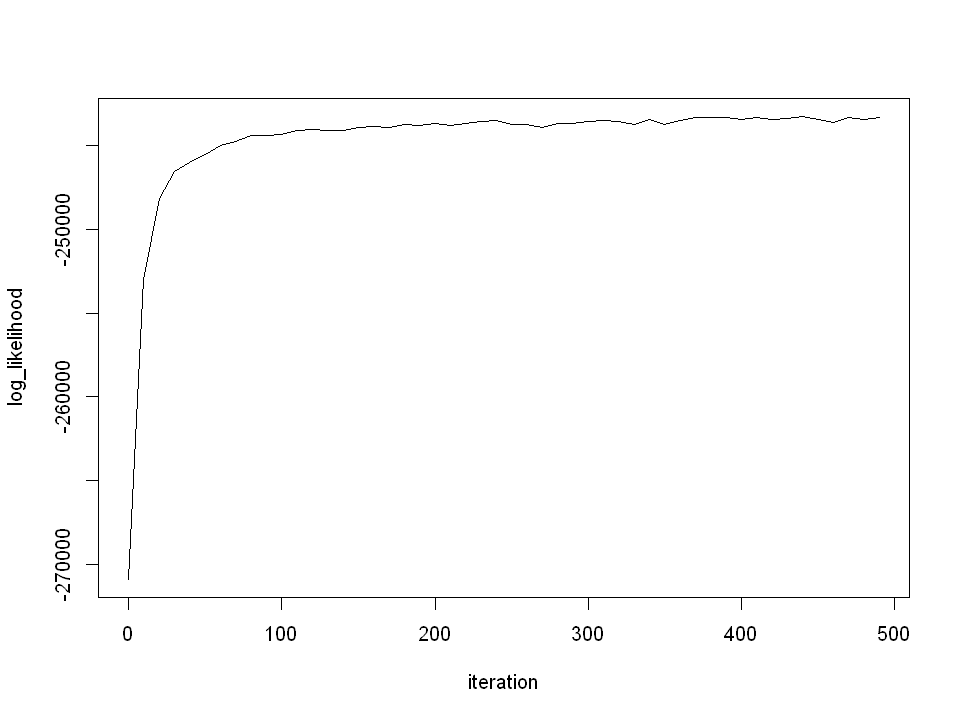

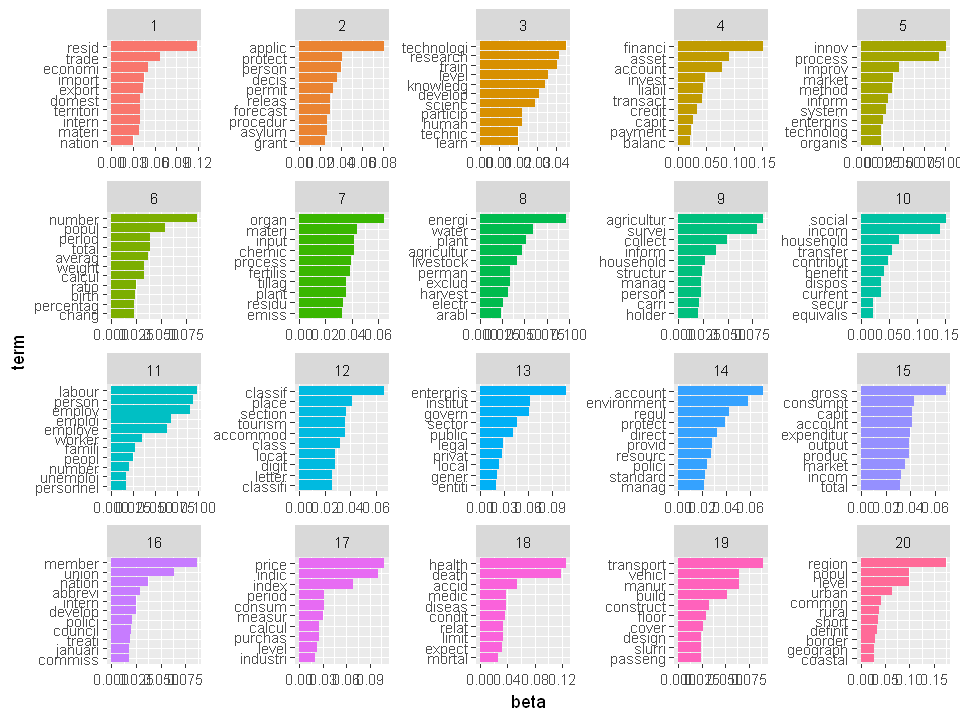

In [5]:
options(repr.plot.width=8, repr.plot.height=6)

lda_model <- 
  FitLdaModel(texts, k=20, iterations = 500, burnin = 400, alpha = 0.1,
beta = 0.05, optimize_alpha = TRUE, calc_likelihood = TRUE,
calc_coherence = TRUE, calc_r2 = FALSE)

#print(lda_model$log_likelihood)
plot(lda_model$log_likelihood, type = "l")

tidy_beta <- data.frame(topic = as.integer(stringr::str_replace_all(rownames(lda_model$phi), "t_", "")), 
                        lda_model$phi, stringsAsFactors = FALSE) %>%
  gather(term, beta, -topic) %>% 
  tibble::as_tibble()

  
top_terms <- tidy_beta %>%
  group_by(topic) %>%
  slice_max(beta, n = 10) %>% 
  ungroup() %>%
  arrange(topic, -beta)

top_terms %>%
  mutate(term = reorder_within(term, beta, topic)) %>%
  ggplot(aes(beta, term, fill = factor(topic))) +
  geom_col(show.legend = FALSE) +
  facet_wrap(~ topic, scales = "free") +
  scale_y_reordered()


The results with the top 10 terms by topic can be interpreted as follows: 

* Topic 1: International trade.
* Topic 2: ???
* Topic 3: Public services.
* Topic 4: Migration and asylum granting.
* Topic 5: Diseases and morbidity.
* Topic 6: Social expenditure and contributions.
* Topic 7: Member states and treaties.
* Topic 8: Household demographics.
* Topic 9: Investments and financial flows.
* Topic 10: Land and water resources.
* Topic 11: Production, consumption and gross domestic product.
* Topic 12: National development policies.
* Topic 13: Technology, research and innovation.
* Topic 14: Surveillance and information on individuals.
* Topic 15: Transport. 
* Topic 16: Agriculture. 
* Topic 17: Price indices. 
* Topic 18: Enterprises. 
* Topic 19: Regions and territories, demographics and geography.  
* Topic 20: Persons and employment.

If these results are useful, the analysis will be extended to take into account the _gamma_ coefficients which express, for each document and topic, the **estimated proportion of terms from the document that are generated from that topic**.

